# 05_find_main_regions
Das Ziel ist es die wichtigsten Regionen in Norwegen für den Schiffsverkehr zu identifizieen
Hierzu sollen verschiedene Cluster Algorithmen verwendet werden

In [3]:
import sys
import os

import yaml
import pandas as pd
import numpy as np
from sqlalchemy import create_engine

import seaborn as sns
import matplotlib.pyplot as plt

from pyod.models.iforest import IForest
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize

from functions.utils import get_folder
from functions.data_loads import get_columns, load_data

curr_folder = get_folder()
parent_fold = curr_folder.parent
with open(parent_fold / "connections.yml", encoding='utf-8') as file:
    db_config = yaml.safe_load(file)
    
with open(parent_fold / "configurations" / "data_loads.yaml", encoding='utf-8') as file:
    column_conf = yaml.safe_load(file)
    
engine = create_engine(f'postgresql+psycopg2://{db_config["user"]}:{db_config["password"]}@{db_config["host"]}:{db_config["port"]}/{db_config["db"]}')

dates = ["01.05.2022","05.05.2022"]

## Load Data

In [4]:
columns = get_columns(engine,'tbl_position_attr',column_conf['position_unrel_cols'])
print(columns)
columns = ['lat_merc','lon_merc','mmsi','msgtime']
data = load_data(engine,'tbl_position_attr',columns)
#data[['lat_merc','lon_merc']] = data[['lat_merc','lon_merc']].round(2)


['aisclass', 'date', 'dow', 'hod', 'lat_merc', 'lon_merc', 'mmsi', 'msgtime', 'sog']


In [5]:
data[['lat_merc','lon_merc']] = data[['lat_merc','lon_merc']].round(2)
data['msgtime'] = data['msgtime'].dt.round('H')
print(data.shape)
data = data.groupby(['lat_merc','lon_merc','mmsi','msgtime']).count().reset_index()
print(data.shape)

(15298039, 4)
(3876550, 4)


In [6]:
data.dropna(inplace=True)
data[(data.lon_merc.isnull()) | (data.lat_merc.isnull())]

,lat_merc,lon_merc,mmsi,msgtime


## Perform K-Means Clustering
Calculiere mit der Elbow Methode die beste Anzahl an Cluster

In [7]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

mask = (data['msgtime'] > dates[0]) & (data['msgtime'] <= dates[1])
X = data[['lat_merc','lon_merc']].loc[mask]
# Stelle die Parameter für den KMeans ein
kmeans_kwargs = {
    "init": "k-means++",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
     }
srange = 10
# Berechne für 15 verschiedene Cluster den Single Square Error
# Es gilt -> je kleiner desto besser
sse = []
for k in range(2, srange):
    print(k)
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)

2
3
4
5
6
7
8
9


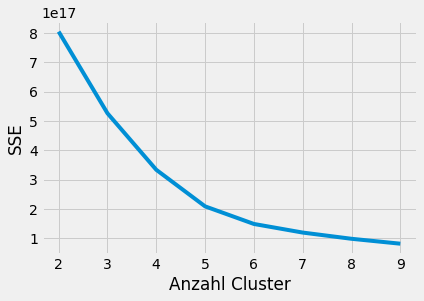

In [8]:
plt.style.use("fivethirtyeight")
plt.plot(range(2, srange), sse)
plt.xticks(range(2, srange))
plt.xlabel("Anzahl Cluster")
plt.ylabel("SSE")
plt.show()

## Trainiere den K-Means mit der "optimalen Anzahl" an Clustern

In [9]:
X = data[['lat_merc','lon_merc']]
true_k = 5
kmeans = KMeans(n_clusters=true_k, init='k-means++', max_iter=300, n_init=10)
kmeans.fit(X)
prediction = kmeans.predict(X)
# Cluster in das Dataframe hinzufügen
data['k_means_pred'] = prediction

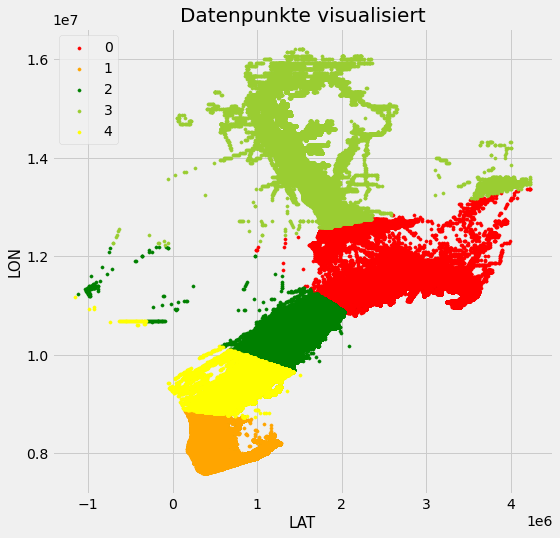

In [10]:
cmap = ["red","orange","green","yellowgreen","yellow","skyblue","blue","darkblue","magenta","purple","grey"]

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('LAT', fontsize = 15)
ax.set_ylabel('LON', fontsize = 15)
ax.set_title('Datenpunkte visualisiert', fontsize = 20)
targets = range(0,true_k)
colors = cmap[:true_k]
for target, color in zip(targets,colors):
    indicesToKeep = data['k_means_pred'] == target
    ax.scatter(data.loc[indicesToKeep, 'lat_merc']
               , data.loc[indicesToKeep, 'lon_merc']
               , c = color
               , s = 10)
ax.legend(targets)

<ipython-input-11-db6259f99e2d>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['k_means_pred'] = prediction


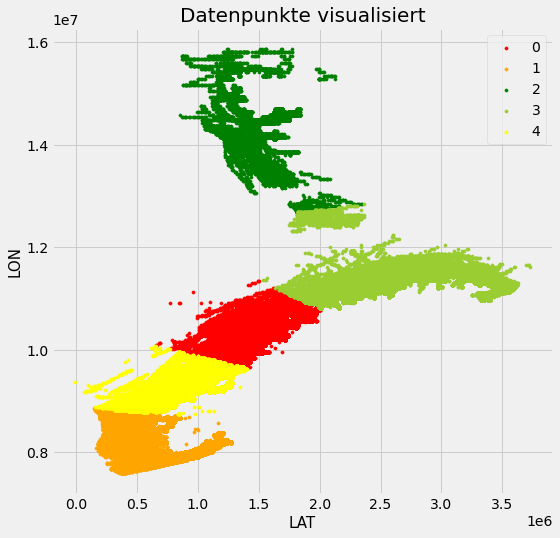

In [11]:
mask = (data['msgtime'] > dates[0]) & (data['msgtime'] <= dates[1])
filtered_data  = data.loc[mask]
X = filtered_data[['lat_merc','lon_merc']]
kmeans = KMeans(n_clusters=true_k, init='k-means++', max_iter=300, n_init=10)
kmeans.fit(X)
prediction = kmeans.predict(X)
# Cluster in das Dataframe hinzufügen
filtered_data['k_means_pred'] = prediction

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('LAT', fontsize = 15)
ax.set_ylabel('LON', fontsize = 15)
ax.set_title('Datenpunkte visualisiert', fontsize = 20)
targets = range(0,true_k)
colors = cmap[:true_k]
for target, color in zip(targets,colors):
    indicesToKeep = filtered_data['k_means_pred'] == target
    ax.scatter(filtered_data.loc[indicesToKeep, 'lat_merc']
               , filtered_data.loc[indicesToKeep, 'lon_merc']
               , c = color
               , s = 10)
ax.legend(targets)

In [12]:
filtered_data.shape

(1390916, 5)

## Perform DBSCAN

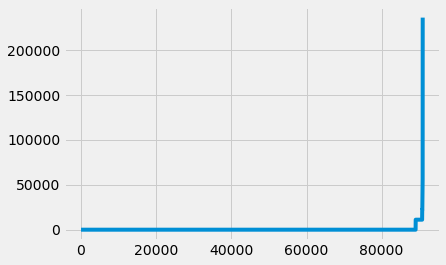

In [13]:
from sklearn.neighbors import NearestNeighbors

neighbors = NearestNeighbors(n_neighbors=4)
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)
distances = np.sort(distances, axis=0)
distances = distances[1300000:1400000,1]
plt.plot(distances)

In [14]:
filtered_data[['lat_merc','lon_merc']][filtered_data.msgtime.dt.hour == 14].shape

(47430, 2)

             lat_merc  lon_merc   mmsi  msgtime  k_means_pred
dbscan_pred                                                  
-1              23002     23002  23002    23002         23002
 0              24428     24428  24428    24428         24428


<ipython-input-15-91fe10798218>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new['dbscan_pred'] = predictions
<ipython-input-15-91fe10798218>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new['dbscan_pred'][new['dbscan_pred'] != -1] = 0
<ipython-input-15-91fe10798218>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new['dbscan_pred'][new['dbscan_pred'] != -1] = 0


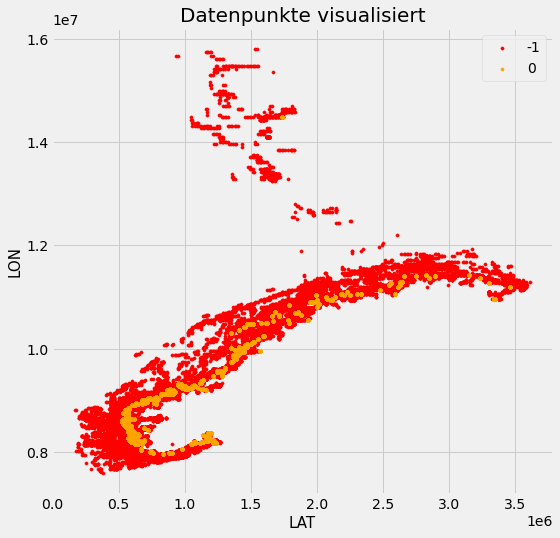

In [15]:
# aufgrund rechenkapazität nur für 1 stunde

from sklearn.cluster import DBSCAN

X = filtered_data[['lat_merc','lon_merc']][filtered_data.msgtime.dt.hour == 14]
db = DBSCAN(eps=0.1, min_samples=30)
predictions = db.fit_predict(X)

new = filtered_data[filtered_data.msgtime.dt.hour == 14] 
new['dbscan_pred'] = predictions
new['dbscan_pred'][new['dbscan_pred'] != -1] = 0
print(new.groupby(['dbscan_pred']).count())
number = new['dbscan_pred'].nunique()

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('LAT', fontsize = 15)
ax.set_ylabel('LON', fontsize = 15)
ax.set_title('Datenpunkte visualisiert', fontsize = 20)
targets = range(-1,number - 1)
colors = cmap[:number]
for target, color in zip(targets,colors):
    indicesToKeep = new['dbscan_pred'] == target
    ax.scatter(new.loc[indicesToKeep, 'lat_merc']
               , new.loc[indicesToKeep, 'lon_merc']
               , c = color
               , s = 10)
ax.legend(targets)

## Perform OPTICS

C:\Users\danie\anaconda3\lib\site-packages\sklearn\cluster\_optics.py:803: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]
<ipython-input-16-11a5074c07ef>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new['optics_pred'] = predictions
<ipython-input-16-11a5074c07ef>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new['optics_pred'][new['optics_pred'] != -1] = 0
<ipython-input-16-11a5074c07ef>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the cavea

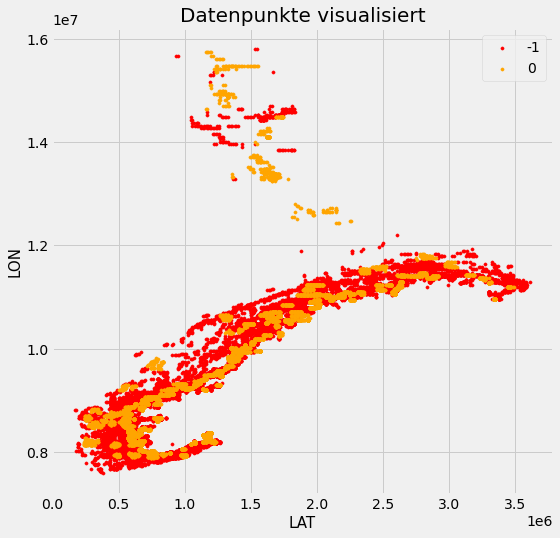

In [16]:
from sklearn.cluster import OPTICS, cluster_optics_dbscan

clust = OPTICS(min_samples=40)

# Run the fit
predictions = clust.fit_predict(X)

new['optics_pred'] = predictions
new['optics_pred'][new['optics_pred'] != -1] = 0

number = new['optics_pred'].nunique()


fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('LAT', fontsize = 15)
ax.set_ylabel('LON', fontsize = 15)
ax.set_title('Datenpunkte visualisiert', fontsize = 20)
targets = range(-1,number -1)
colors = cmap[:number]
for target, color in zip(targets,colors):
    indicesToKeep = new['optics_pred'] == target
    ax.scatter(new.loc[indicesToKeep, 'lat_merc']
               , new.loc[indicesToKeep, 'lon_merc']
               , c = color
               , s = 10)
ax.legend(targets)

## Entscheidung für Algorithmus 
* Während der K_Means 5 Cluster einfärbt hat er keine Möglichkeit "Noise" zu identifieren.
* DBSCAN und OPTICS können beide Noise identifizieren. Die unterschiedlichen Cluster sind weniger interessant. Nur die unterscheidung Noise / Kein Noise ist interessant.
* Darum wurden die cluster alle = 0 gesetzt. Und Noise = -1
* OPTICS ist dabei in der Lage auch unterschiedliche Densitys zu erkennen und in ein cluster zu packen. Bei real life geodaten kann dies ein vorteil sein. Da hier die Cluster unterschiedliche dichten aufweisen könnten
* Ohne weiteres Feintuning liefert der DBSCan aber bessere Ergebnisse. Hier ist die Küstenlinie besser nachgezeichnet. Deshalb werden die Ergebnisse aus diesem weiterverwendet

## Filter auf Locations die wichtig sind und finden der nächsten norwegischen Stadt

In [23]:
locations = new[['lat_merc','lon_merc']][new.dbscan_pred != -1].groupby(['lat_merc','lon_merc']).count().reset_index()
print( "Folgende Anzahl an Locations sind in Norwegen wichtig:", locations.shape)
locations.to_csv("important_locations.csv",sep=';',index=False)

Folgende Anzahl an Locations sind in Norwegen wichtig: (339, 2)


In [28]:
locations = pd.read_csv("important_locations.csv",sep=';')
locations.head()

,lat_merc,lon_merc
0,523201.61,8580044.13
1,523201.61,8625823.20
2,534333.56,8557261.74
3,534333.56,8580044.13
4,534333.56,8602897.78


###für die städte wurde folgende quelle genutzt: 
* Bezugsdatum: 24.09.2022
    * https://simplemaps.com/data/no-cities

In [29]:
from functions.data_cleaning import create_mercator

cities = pd.read_csv(curr_folder / "norway_cities.csv", sep= ',')
cities = create_mercator(cities,{'x':'lat','y':'lng'})
cities.head()

,city,lat,lng,country,iso2,admin_name,capital,population,population_proper,lat_merc,lng_merc
0,Oslo,59.9111,10.7528,Norway,NO,Oslo,primary,693494.0,693494.0,1.196996e+06,8.379972e+06
1,Bergen,60.3925,5.3233,Norway,NO,Hordaland,admin,257087.0,257087.0,5.925870e+05,8.487647e+06
2,Trondheim,63.4400,10.4000,Norway,NO,Sør-Trøndelag,minor,183378.0,183378.0,1.157723e+06,9.208962e+06
3,Stavanger,58.9701,5.7333,Norway,NO,Rogaland,admin,129300.0,129300.0,6.382280e+05,8.173927e+06
4,Drammen,59.7439,10.2045,Norway,NO,Buskerud,minor,117510.0,117510.0,1.135960e+06,8.342939e+06


In [34]:
from scipy import spatial



tree = spatial.KDTree(cities[['lat_merc','lng_merc']])
distance, index = tree.query(locations[['lat_merc','lon_merc']])
locations['cities'] = index
locations['cities'] = locations['cities'].apply(lambda x: cities['city'].loc[x])


locations.head()

,lat_merc,lon_merc,cities
0,523201.61,8580044.13,Fedje
1,523201.61,8625823.20,Hardbakke
2,534333.56,8557261.74,Fedje
3,534333.56,8580044.13,Fedje
4,534333.56,8602897.78,Fedje


In [35]:
locations.tail(5)

,lat_merc,lon_merc,cities
334,3239397.18,11368166.13,Berlevåg
335,3306188.88,11266869.62,Båtsfjord
336,3339584.72,10971767.97,Kirkenes
337,3350716.67,10971767.97,Kirkenes
338,3462036.16,11200172.10,Vardø


In [38]:
## save your import locations in the database in own table
locations.to_sql("tbl_important_locations",engine,if_exists='replace', index=False)

339